# Set up

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(),'../CIBUSmod')) # <--- Ändra här

In [2]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from SAFAD_interface import SAFAD_interface

In [3]:
# Create session object
session = cm.Session(
    name = 'SLV',
    data_path = '../CIBUSmod/data',
    data_path_output = 'output',
    data_path_scenarios = 'scenarios'
)

SCN_NAME = 'SLV' # <--- Ändra här

In [4]:
def scn_tuple(y, long=False):
    pos_1 = {'1':'5%', '2':'30%'}
    pos_2 = {'1':'CMS','2':'SE','3':'SE (all)'}
    pos_3 = {'1':'C','2':'PB'}
    pos_4 = {'0':'None'}
    if long:
        pos_2 = {'1':'Current market shares','2':'Swedish','3':'Swedish (all consumers)'}
        pos_3 = {'1':'Chicken','2':'Plant-based'}
    
    if y == '0':
        return ('BL',pos_2['1'],'')
    else:
        return (pos_1[y[0]], pos_2[y[1]], pos_3[y[2]], )
        
def make_scn_idx(idx):

    return pd.MultiIndex.from_tuples(
        [scn_tuple(y) for y in idx.get_level_values('year')],
        names = ['Compliance', 'Origin, meat', 'Substitute']
    )

CO2e_method = 'GWP100 AR6'

bar_style = {
    'cmap':'Accent',
    'group_levels':['Compliance','Substitute'],
    'grouplabels_fontsize':9,
    'ticklabels_fontsize':9,
    'grouptitle_fontsize':10,
    'ylabel_fontsize':10,
    'xlabel_fontsize':10,
    'xlabel':'Origion of red meat',
    'grouptitle':'Compliance and substitute',
}

bar_style2 = {k:v for k,v in bar_style.items() if k != 'cmap'}

def style_bar(ax, d):
    if isinstance(d, pd.DataFrame):
        ax.legend(
            ncol=1, fontsize=8, reverse=True,
            bbox_to_anchor=(1,1), frameon=False
        )
    ax.axhline(d.loc['BL'].iloc[0].sum(), color='black', linestyle='--', linewidth=0.5)

In [5]:
session.cache.clear()

# Calculate impacts from changed imports

In [53]:
SAFAD = SAFAD_interface('SAFAD_data')
SAFAD_sens = SAFAD_interface('SAFAD_data')
SAFAD.read_data('footprints','SAFAD_data/SAFAD ID Footprints RPC_add_BR.csv') # <-- Add data from Brazil (also used for Argentina)
SAFAD_sens.read_data('footprints','SAFAD_data/SAFAD ID Footprints RPC_sens.csv') # <-- Sensitivity analysis only Irish suckler cows for beef imports (Moberg)

to_SAFAD_codes = {
    'food' : pd.read_csv('food_to_SAFAD_codes.csv', index_col='food')['code'].dropna().to_dict(),
    'by_prod' : pd.read_csv('by_prod_to_SAFAD_codes.csv', index_col='by_prod')['code'].dropna().to_dict(),
    'crop_prod' : pd.read_csv('crop_prod_to_SAFAD_codes.csv', index_col='crop_prod')['code'].dropna().to_dict()
}

def get_ghg(SAFAD, df, CO2eq):
    dfs = []
    item = df.columns.name
    for col in df:
        dfs.append(pd.concat({col: SAFAD.get_GHG(to_SAFAD_codes[item][col], CO2eq=CO2eq)}, names=[item]))
    return df.mul(pd.concat(dfs), axis=1)

def get_footprint(SAFAD, df, footprint):
    dfs = []
    item = df.columns.name
    for col in df:
        dfs.append(pd.concat({col: SAFAD.get_footprints(to_SAFAD_codes[item][col]).loc[footprint]}, names=[item]))
    return df.mul(pd.concat(dfs), axis=1)

In [54]:
food_dict = {
    'Bovine meat and products' : '$\Delta$ red meat imports',
    'Broad beans and horse beans, dry' : '$\Delta$ substitute imports',
    'Mutton/goat meat' : '$\Delta$ red meat imports',
    'Peas, dry' : '$\Delta$ substitute imports',
    'Pig meat and products' : '$\Delta$ red meat imports',
    'Poultry meat and products' : '$\Delta$ substitute imports',
    'Rape and mustard oil and products' : '$\Delta$ substitute imports'
}

# Get food imports
food_import = session.get_attr('d','food_demand_to_processing',['origin','food']).loc[:,'imported']
# Calculate change from baseline and drop all foods with no change
food_import_chg = food_import.sub(food_import.loc[('SLV','0')], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)

# Adjust to align conversion factors CW --> BFM
# Clune et al (2017) are used in SAFAD data
food_import_chg.loc[:,'Bovine meat and products'] *= (0.695/0.75)
food_import_chg.loc[:,'Mutton/goat meat'] *= (0.66/0.69)
food_import_chg.loc[:,'Pig meat and products'] *= (0.59/0.71)
food_import_chg.loc[:,'Poultry meat and products'] *= (0.77/0.87)

food_import_CO2e_details = get_ghg(SAFAD, food_import_chg, CO2eq=CO2e_method)
food_import_CO2e_details_sens = get_ghg(SAFAD_sens, food_import_chg, CO2eq=CO2e_method)
food_import_CO2e = food_import_CO2e_details.rename(columns=food_dict).T.groupby('food').sum().T
food_import_CO2e_excl_LUC = food_import_CO2e_details.drop('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby('food').sum().T
food_import_CO2e_excl_LUC_sens = food_import_CO2e_details_sens.drop('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby('food').sum().T
food_import_GHG = get_ghg(SAFAD, food_import_chg, CO2eq=False).rename(columns=food_dict).T.groupby(['food','compound']).sum().T
food_import_land = get_footprint(SAFAD, food_import_chg, 'Land').rename(columns=food_dict).T.groupby('food').sum().T / 10_000
food_import_ammonia = get_footprint(SAFAD, food_import_chg, 'Ammonia').rename(columns=food_dict).T.groupby('food').sum().T

In [55]:
# Get by-product imports
byprod_import = session.get_attr('d','by_products',['origin','by_prod']).loc[:,'imported']
# Get by-product exports
byprod_export = session.get_attr('d','by_prod_demand',['demand','by_prod']).loc[:,'export']
# Calculate net imports
byprod_import = byprod_import.sub(byprod_export, fill_value=0)
# Calculate change from baseline and drop all by-products with no change
byprod_import_chg = byprod_import.sub(byprod_import.loc[('SLV','0')], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)

byprod_import_CO2e = get_ghg(SAFAD, byprod_import_chg, CO2eq=CO2e_method).sum(axis=1).rename('$\Delta$ feed imports')
byprod_import_CO2e_excl_LUC = get_ghg(SAFAD, byprod_import_chg, CO2eq=CO2e_method).drop('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
byprod_import_land = get_footprint(SAFAD, byprod_import_chg, 'Land').sum(axis=1).rename('$\Delta$ feed imports') / 10_000
byprod_import_ammonia = get_footprint(SAFAD, byprod_import_chg, 'Ammonia').sum(axis=1).rename('$\Delta$ feed imports')

# Get feed imports
feed_import = session.get_attr('a','feed.crop_product_demand',['origin','crop_prod']).loc[:,'imported']
# Calculate change from baseline and drop all by-products with no change
feed_import_chg = feed_import.sub(feed_import.loc[('SLV','0')], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)

feed_import_CO2e = get_ghg(SAFAD, feed_import_chg, CO2eq=CO2e_method).sum(axis=1).rename('$\Delta$ feed imports')
feed_import_CO2e_excl_LUC = get_ghg(SAFAD, feed_import_chg, CO2eq=CO2e_method).drop('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
feed_import_land = get_footprint(SAFAD, feed_import_chg, 'Land').sum(axis=1).rename('$\Delta$ feed imports') / 10_000
feed_import_ammonia = get_footprint(SAFAD, feed_import_chg, 'Ammonia').sum(axis=1).rename('$\Delta$ feed imports')

feed_import_CO2e += byprod_import_CO2e
feed_import_CO2e_excl_LUC += byprod_import_CO2e_excl_LUC
feed_import_land += byprod_import_land
feed_import_ammonia += byprod_import_ammonia

# Calculate impacts from LUC in Sweden

In [56]:
# Emission factors for LUC derived from Sweden's national inventory reports
# Averaged over 10 year (2013-2022). kg CO2 per ha
EF_cropland_to_forest = -1779
EF_grassland_to_forest = -1399
EF_forest_to_cropland = 7605
EF_forest_to_grassland = 9287
# Amortization period for LUC emissions, same as in Pendrill et al. (2019)
# "Agricultural and forestry trade drives large share of tropical deforestation emissions"
amort_period = 10

EF = pd.Series({
    'cropland':EF_forest_to_cropland,
    'semi-natural grasslands':EF_forest_to_grassland
})

swe_LUC = (
    session.get_attr('c','area',{'crop':'land_use'})
    .pipe(lambda df: df - df.iloc[0])
    .mul(EF, axis=1)
    .div(amort_period)
    .sum(axis=1)
    .rename('land use change (SE)')
)

# Cropland use

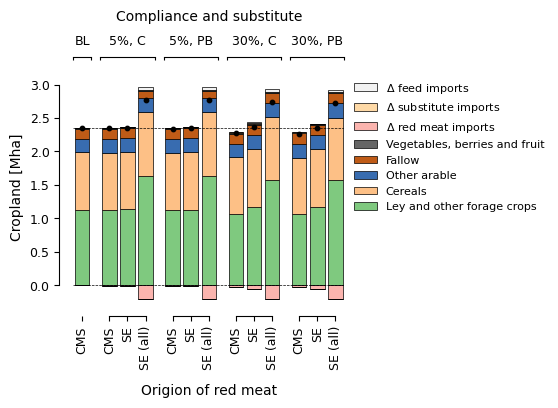

In [57]:
from matplotlib.colors import ListedColormap
colors = [plt.colormaps['Accent'](i/4) for i in range(5)]\
+ [plt.colormaps['Pastel1'](i/2) for i in range(3)]

d = (
    session.get_attr('c','area',{'crop':['land_use','crop_group2']})
    .loc[:,'cropland']
    .sort_values(axis=1, by=('SLV','0'), ascending=False)
    .rename(columns={'Fodder crops':'Ley and other forage crops'})
    .join(food_import_land)
    .join(feed_import_land)
) / 1_000_000
d = d.set_index(make_scn_idx(d.index))

fig,ax = plt.subplots(figsize=(3.5,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Cropland [Mha]',
    ylim=(-0.25,3.2),
    cmap=ListedColormap(name='X', colors=colors),
    **bar_style2
)
style_bar(ax, d)
plt.show()

t = d.iloc[:,0:5].sum(axis=1)
t = (t-t.iloc[0]) / t.iloc[0] * 100
display(t.to_frame().style.format(precision=1))

t = d.iloc[:,0:5].sum(axis=1)
display(t.to_frame().style.format(precision=1))

In [58]:
session.get_attr('c','area','crop').loc[:,'Fallow']/1_000

scn  year
SLV  0       151.996396
     1110    151.998513
     1120    151.998537
     1210    151.998717
     1220    151.998927
     1310    101.455192
     1320    101.386400
     2110    152.020551
     2120    152.047154
     2210    152.008505
     2220    152.032684
     2310    141.836580
     2320    141.711414
Name: Fallow, dtype: float64

In [59]:
session.get_attr('c','area','crop').loc[:,'Ley not harvested']/1_000

scn  year
SLV  0       50.843814
     1110    50.844037
     1120    50.844038
     1210    50.844061
     1220    50.844078
     1310    33.228650
     1320    33.210936
     2110    50.846495
     2120    50.853532
     2210    50.845086
     2220    50.851356
     2310    46.415129
     2320    46.395876
Name: Ley not harvested, dtype: float64

In [60]:
session.get_attr('r','max_land_use','land_use')

land_use      cropland  greenhouse  semi-natural grasslands
scn year                                                   
SLV 0     2.532288e+06   1365697.5             4.559172e+05
    1110  2.918490e+06   1365697.5             1.388863e+06
    1120  2.918490e+06   1365697.5             1.388863e+06
    1210  2.918490e+06   1365697.5             1.388863e+06
    1220  2.918490e+06   1365697.5             1.388863e+06
    1310  2.918490e+06   1365697.5             1.388863e+06
    1320  2.918490e+06   1365697.5             1.388863e+06
    2110  2.918490e+06   1365697.5             1.388863e+06
    2120  2.918490e+06   1365697.5             1.388863e+06
    2210  2.918490e+06   1365697.5             1.388863e+06
    2220  2.918490e+06   1365697.5             1.388863e+06
    2310  2.918490e+06   1365697.5             1.388863e+06
    2320  2.918490e+06   1365697.5             1.388863e+06

# Semi-natural grasslands

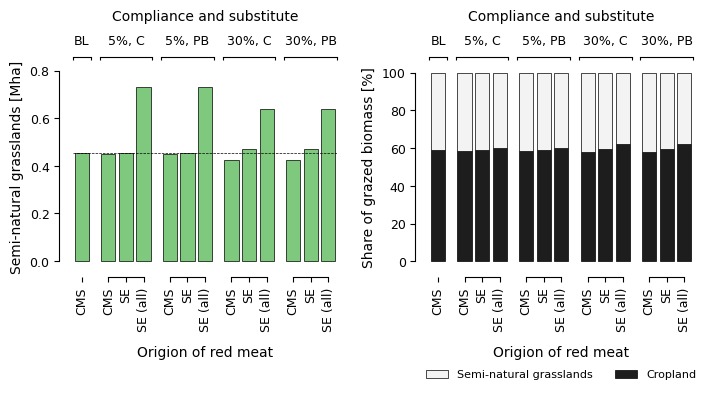

In [67]:
fig,axs = plt.subplots(1,2, figsize=(8,2.5), gridspec_kw={'wspace':0.35})

d1 = (
    session.get_attr('c','area',{'crop':['land_use']})
    .loc[:,'semi-natural grasslands']
) / 1_000_000
d1.index = make_scn_idx(d1.index)
ax = axs[0]
ax, axgs = cm.plot.bar(
    d1,
    ax = ax,
    ylabel='Semi-natural grasslands [Mha]',
    **bar_style,
    ylim=(-0.01,0.8)
)
axgs[0].set_xticklabels(['BL'])
style_bar(ax, d1)

d2 = (
    session.get_attr('c','production',{'crop_prod':None, 'crop':'land_use'})
    .loc[:,'grazing']
    .rename(columns=lambda x: x.capitalize())
    .apply(lambda x: x/x.sum()*100, axis=1)
)
d2.index = make_scn_idx(d2.index)

ax = axs[1]
cm.plot.bar(
    d2,
    ax = ax,
    ylabel='Share of grazed biomass [%]',
    cmap='Greys',
    **bar_style2,
)
ax.legend(
    ncol=2, fontsize=8, reverse=True,
    bbox_to_anchor=(1.05,-0.5), frameon=False
)

plt.show()
t = (d1-d1.iloc[0]).div(d1.iloc[0]).mul(100)
display(t.to_frame().style.format(precision=1))

# Animal numbers

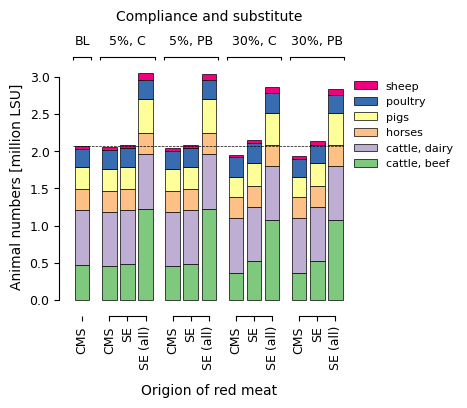

In [46]:
d = cm.impact.get_LSU(session, ['species','breed']) / 1_000_000
d.columns = pd.Index([sp if sp not in ['cattle'] else ', '.join([sp,br]) for sp,br in d.columns], name='type')
d = d.T.groupby('type').sum().T
d = d.set_index(make_scn_idx(d.index))

fig,ax = plt.subplots(figsize=(3.5,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Animal numbers [million LSU]',
    **bar_style
)
style_bar(ax, d)
plt.show()

In [47]:
display((d-d.iloc[0]).div(d.iloc[0], axis=1).mul(100).style.format(precision=1))

In [53]:
session.cache.clear()

In [55]:
d = session.get_attr('g','x_animals',['species','sub_system']).loc[:,'sheep']

display(100-d.pipe(lambda df: df.div(df.sum(axis=1), axis=0)*100)['other sheep'])
d.drop('other sheep', axis=1).pipe(lambda df: df.div(df.sum(axis=1), axis=0)*100)

scn  year
SLV  0       57.100000
     1110    56.636722
     1120    56.636990
     1210    57.821989
     1220    57.821989
     1310    78.996107
     1320    78.996107
     2110    54.187530
     2120    54.192830
     2210    62.506430
     2220    62.506430
     2310    77.396579
     2320    77.396579
Name: other sheep, dtype: float64

sub_system  autumn lamb  spring lamb  winter lamb
scn year                                         
SLV 0         43.432574    31.523643    25.043783
    1110      44.721952    30.029412    25.248636
    1120      44.700589    30.050894    25.248517
    1210      54.218128    29.573524    16.208348
    1220      54.218128    29.573524    16.208348
    1310      50.546795    27.570979    21.882227
    1320      50.546795    27.570979    21.882227
    2110      51.103658    22.506506    26.389835
    2120      50.684826    22.927919    26.387255
    2210      52.794568    28.797037    18.408394
    2220      52.794568    28.797037    18.408394
    2310      51.165052    27.908210    20.926738
    2320      51.165052    27.908210    20.926738

In [49]:
session.cache.clear()

# Climate impact

Default


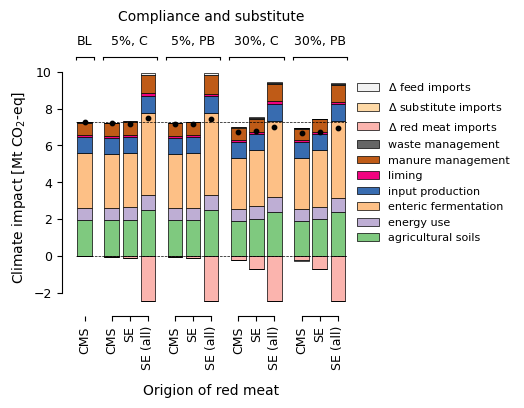

Incl. LUC


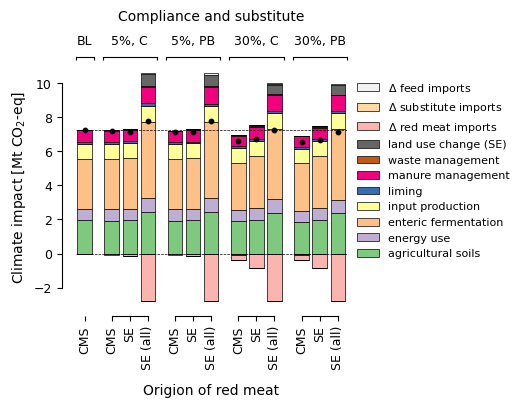

Only Irish suckler cows


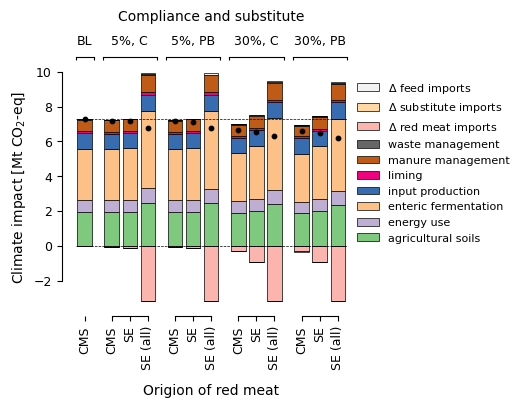

In [63]:
from matplotlib.colors import ListedColormap

d = (
    cm.impact.get_GHG(session, CO2eq=CO2e_method)
    .drop('organic soils', level='sub-process', axis=1)
    
    .T.groupby('process').sum().T
    .rename(columns={'waste and circularity':'waste management'})
) / 1_000_000_000
d1 = (
    d
    .join(food_import_CO2e_excl_LUC / 1_000_000_000)
    .join(feed_import_CO2e_excl_LUC / 1_000_000_000)
)
d2 = (
    d
    .join(swe_LUC / 1_000_000_000)
    .join(food_import_CO2e / 1_000_000_000)
    .join(feed_import_CO2e / 1_000_000_000)
)
d3 = (
    d
    .join(food_import_CO2e_excl_LUC_sens / 1_000_000_000)
    .join(feed_import_CO2e_excl_LUC / 1_000_000_000)
) 

d1.set_index(make_scn_idx(d1.index), inplace=True)
d2.set_index(make_scn_idx(d2.index), inplace=True)
d3.set_index(make_scn_idx(d3.index), inplace=True)

for dx in [d1,d2,d3]:

    if dx is d1:
        print('Default')
    if dx is d2:
        print('Incl. LUC')
    if dx is d3:
        print('Only Irish suckler cows')
    len(dx.columns) - 3
    colors = [plt.colormaps['Accent'](i/(len(dx.columns)-3-1)) for i in range(len(dx.columns)-3)]\
        + [plt.colormaps['Pastel1'](i/2) for i in range(3)]
    
    fig,ax = plt.subplots(figsize=(3.5,3))
    ax,axgs = cm.plot.bar(
        dx,
        ax=ax,
        cmap=ListedColormap(name='X', colors=colors),
        ylabel='Climate impact [Mt CO$_2$-eq]',
        **bar_style2
    )
    style_bar(ax, dx)
    plt.show()
    
    display((
        dx
        .sum(axis=1)
        / dx.iloc[0].sum() * 100 - 100
    ).to_frame().style.format(precision=2))

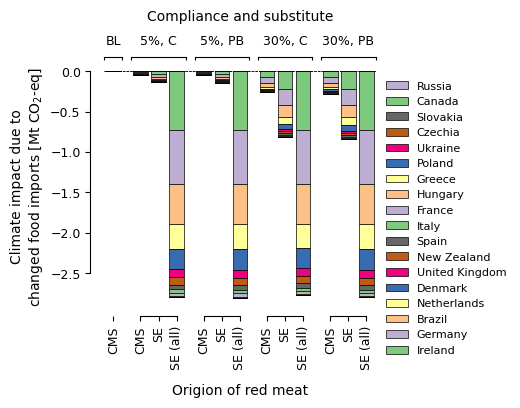

In [64]:
d = (
    food_import_CO2e_details
    .T.groupby('country').sum().T
) / 1_000_000_000
d.set_index(make_scn_idx(d.index), inplace=True)
d

fig,ax = plt.subplots(figsize=(3.5,3))
ax,axgs = cm.plot.bar(
    d,
    ax=ax,
    sort_categories=True,
    ylabel='Climate impact due to\nchanged food imports [Mt CO$_2$-eq]',
    totmarker='none',
    **bar_style
)
style_bar(ax, d)
plt.show()

# Ammonia

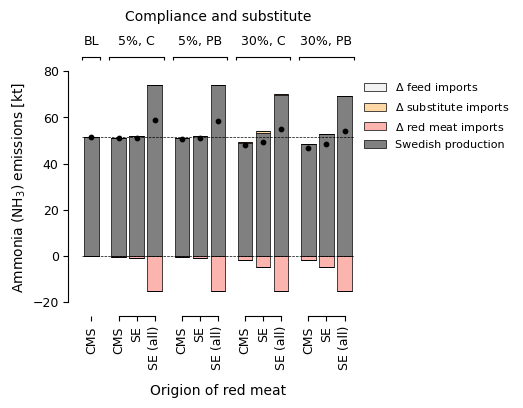

In [46]:
from matplotlib.colors import ListedColormap
colors = ['grey']\
+ [plt.colormaps['Pastel1'](i/2) for i in range(3)]

d = (
    cm.impact.get_emissions(session)
    .drop('organic soils', level='sub-process', axis=1)
    .rename(columns={'waste and circularity':'waste management'})
    .T.groupby('compound').sum().loc['NH3-N'].T
    .mul((14+3)/14)
    .rename('Swedish production').to_frame()
    .join(food_import_ammonia)
    .join(feed_import_ammonia)
     / 1_000_000
)
d.set_index(make_scn_idx(d.index), inplace=True)

fig,ax = plt.subplots(figsize=(3.5,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Ammonia (NH$_3$) emissions [kt]',
    cmap=ListedColormap(name='X', colors=colors),
    ylim = (-20,80),
    **bar_style2
)

style_bar(ax, d)

plt.show()

# Maps

In [8]:
map_style1 = {
    'cmap' : 'BrBG',
    'edgecolor' : 'grey'
}
map_style2 = {
    'cmap' : 'YlOrBr',
    'edgecolor' : 'grey'
}

## Cropland

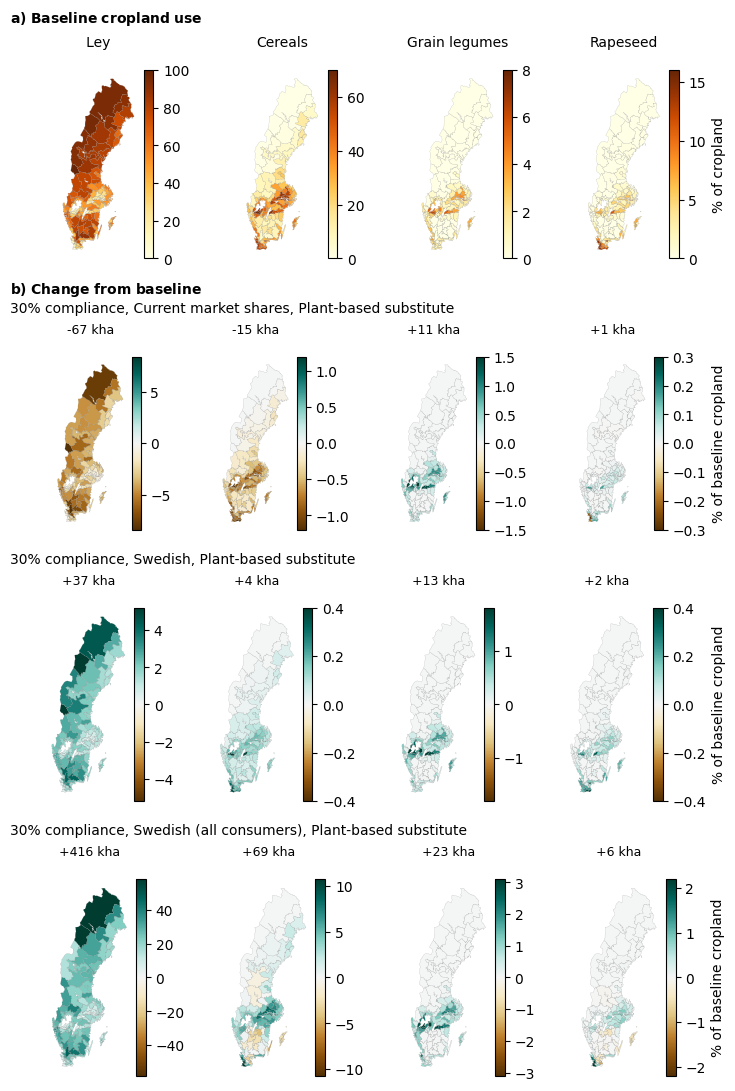

In [45]:
scns = ['2120','2220','2320']
scn_titles = {0 : r'$\bf{a)}$ $\bf{Baseline}$ $\bf{cropland}$ $\bf{use}$'}

for i, scn in enumerate(scns):
    if i == 0:
        str = r'$\bf{b)}$ $\bf{Change}$ $\bf{from}$ $\bf{baseline}$'+'\n'
    else:
        str = ''
    tpl = scn_tuple(scn, long=True)
    str += f'{tpl[0]} compliance, {tpl[1]}, {tpl[2]} substitute'.replace("\n","")
    scn_titles.update(
        {i+1:str}
    )

plot_data = (
    session.get_attr('C', 'area', {'crop':['land_use','crop_group'], 'region':None})
    .loc['SLV','cropland']
    .T
    .rename({'Cereals, winter':'Cereals', 'Cereals, spring':'Cereals'})
    .groupby(['crop_group','region'])
    .sum()
)

plot_data1_nat = plot_data.groupby('crop_group').sum()/1000
plot_data1 = plot_data.div(plot_data.groupby('region').sum()['0'], axis=0) * 100

plot_data2 = plot_data1.sub(plot_data1['0'], axis=0)
plot_data2_nat = plot_data1_nat.sub(plot_data1_nat['0'], axis=0)

crps = ['Ley','Cereals','Grain legumes','Brassicaceae']

h = 2.7
w = 1.8
fig = plt.figure(constrained_layout=True, figsize=(w*len(crps), h+h*len(scns)))
# fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=len(scns)+1, ncols=1)
for row, subfig in enumerate(subfigs):
    
    axs = subfig.subplots(nrows=1, ncols=len(crps))
    subfig.suptitle(scn_titles[row], x=0, ha='left', size=10)
    if row==0:
        for crp, ax in zip(crps,axs):
            map_data = plot_data1['0'].loc[crp]
            lim = np.ceil(map_data.max()/2)*2
            leg_str = '% of cropland' if crp==crps[-1] else ''
            plot.map_from_series(map_data, vmin=0, vmax=lim, **map_style2, ax=ax, legend_kwds={'label': leg_str})
            ax.axis('off')
            ax.set_title('Rapeseed' if crp == 'Brassicaceae' else '   Ley   ' if crp=='Ley' else crp, size=10)
        
    else:
        scn = scns[row-1]
        for crp, ax in zip(crps,axs):
            map_data = plot_data2[scn].loc[crp]
            # lim = np.ceil(abs(plot_data2[scns].loc[crp]).quantile(0.99).max())
            lim = np.ceil(abs(map_data).quantile(0.99).max()*10)/10
            leg_str = '% of baseline cropland' if crp==crps[-1] else ''
            plot.map_from_series(map_data, vmin=-lim, vmax=lim, **map_style1, ax=ax, legend_kwds={'label': leg_str})
            ax.axis('off')
            nat_chg = plot_data2_nat[scn][crp]
            ax.set_title(f'{nat_chg:+.0f} kha', size=9)

# plt.savefig('map_cropland.png')
plt.show()

In [30]:
np.linspace(-lim,lim,6)

array([-3. , -1.8, -0.6,  0.6,  1.8,  3. ])

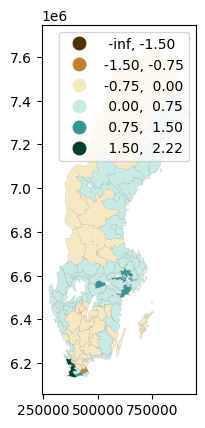

In [39]:
cm.plot.map_from_series(
    map_data,
    **map_style1,
    scheme = 'User_defined',
    classification_kwds=dict(bins=np.linspace(-1.5,1.5,5))
)

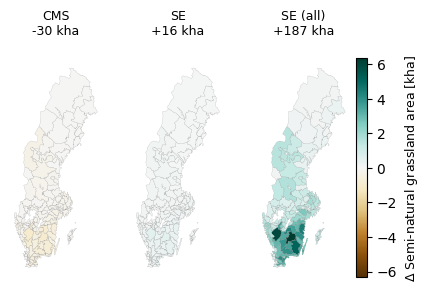

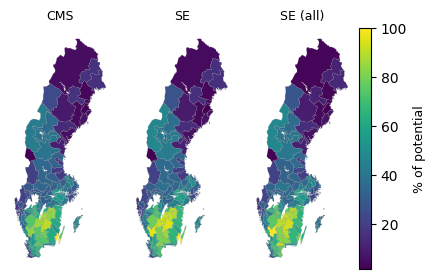

In [96]:
m = (
    session.get_attr('r','max_land_use',{'land_use':None, 'region':None})
    .loc[:,'semi-natural grasslands']
    .droplevel('scn')
)

d1 = (
    session.get_attr('c','area',{'crop':'land_use', 'region':None})
    .loc[:,'semi-natural grasslands']
    .droplevel('scn')
    .pipe(lambda df: df.sub(df.iloc[0], axis=1))
) / 1_000

d2 = (
    session.get_attr('c','area',{'crop':'land_use', 'region':None})
    .loc[:,'semi-natural grasslands']
    .droplevel('scn')
    .div(m) * 100
)

scns = ['2120','2220','2320']

d = d1
fig,axs = plt.subplots(1,len(scns), figsize=(1.5*len(scns), 3), gridspec_kw={'width_ratios':(1,)*(len(scns)-1)+(1.2,)})
lim = d.loc[scns].abs().max().max()
for ax, scn in zip(axs,scns):
    
    cm.plot.map_from_series(
        d.loc[scn],
        ax=ax,
        vmin = -lim,
        vmax = lim,
        legend = True if ax is axs[-1] else False,
        **map_style1
    )
    cbar = ax.get_figure().axes[-1]
    cbar.set_ylabel('$\Delta$ Semi-natural grassland area [kha]', fontsize=9)
    t = scn_tuple(scn, long=False)
    ax.set_title(f'{t[1]}\n{d.loc[scn].sum():+.0f} kha', size=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

d = d2
fig,axs = plt.subplots(1,len(scns), figsize=(1.5*len(scns), 3), gridspec_kw={'width_ratios':(1,)*(len(scns)-1)+(1.2,)})
for ax, scn in zip(axs,scns):
    
    cm.plot.map_from_series(
        d.loc[scn],
        ax=ax,
        legend = True if ax is axs[-1] else False,
        cmap='viridis',
        edgecolor='grey'
    )
    cbar = ax.get_figure().axes[-1]
    cbar.set_ylabel('% of potential', fontsize=9)
    t = scn_tuple(scn, long=False)
    ax.set_title(t[1], size=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Use of cereals

In [131]:
d = (
    session.get_attr('c','production_per_use',{'crop':'crop_group2','demand':None})
    .loc[:,'Cereals']
    .rename(columns=lambda x: 'feed' if 'feed' in x else x)
    .T.groupby('demand').sum().T
    .apply(lambda x: x/x.sum()*100, axis=1)
)
d.set_index(make_scn_idx(d.index), inplace=True)
d['food+export'] = d['food'] + d['export']

demand                                               export       feed  \
Compliance Origin, meat            Substitute                            
BL         Current market shares   None           26.368833  41.703999   
5%         Current market shares   \nChicken      26.395191  41.649952   
                                   \nPlant-based  26.452292  41.530434   
           Swedish                 \nChicken      26.286906  41.875052   
                                   \nPlant-based  26.341246  41.761298   
           Swedish (all consumers) \nChicken      23.842328  46.958691   
                                   \nPlant-based  23.891380  46.855937   
30%        Current market shares   \nChicken      26.461558  41.515680   
                                   \nPlant-based  26.832628  40.739500   
           Swedish                 \nChicken      25.909238  42.664256   
                                   \nPlant-based  26.262001  41.926238   
           Swedish (all consumers) \nChicken      24.116295  46.392333   
                                   \nPlant-based  24.421833  45.752660   

demand                                                 food   non-food  \
Compliance Origin, meat            Substitute                            
BL         Current market shares   None           16.371904  12.114378   
5%         Current market shares   \nChicken      16.388269  12.126487   
                                   \nPlant-based  16.423722  12.152721   
           Swedish                 \nChicken      16.321037  12.076739   
                                   \nPlant-based  16.354776  12.101704   
           Swedish (all consumers) \nChicken      14.803246  10.953650   
                                   \nPlant-based  14.833701  10.976186   
30%        Current market shares   \nChicken      16.429476  12.156978   
                                   \nPlant-based  16.659866  12.327455   
           Swedish                 \nChicken      16.086550  11.903230   
                                   \nPlant-based  16.305574  12.065297   
           Swedish (all consumers) \nChicken      14.973347  11.079516   
                                   \nPlant-based  15.163049  11.219886   

demand                                                seed  food+export  
Compliance Origin, meat            Substitute                            
BL         Current market shares   None           3.440887    42.740737  
5%         Current market shares   \nChicken      3.440102    42.783460  
                                   \nPlant-based  3.440831    42.876015  
           Swedish                 \nChicken      3.440266    42.607943  
                                   \nPlant-based  3.440977    42.696021  
           Swedish (all consumers) \nChicken      3.442085    38.645574  
                                   \nPlant-based  3.442796    38.725081  
30%        Current market shares   \nChicken      3.436309    42.891034  
                                   \nPlant-based  3.440551    43.492494  
           Swedish                 \nChicken      3.436725    41.995788  
                                   \nPlant-based  3.440890    42.567575  
           Swedish (all consumers) \nChicken      3.438509    39.089642  
                                   \nPlant-based  3.442571    39.584882

# TEST SAFAD

In [ ]:
codes = pd.read_csv('SAFAD_data/SAFAD IP Recipes.csv')['Food code'].unique()
len(codes)

for c in codes:
    try:
        print(c,end=': ')
        print(round(
            SAFAD.get_footprints(c)['Carbon footprint, primary production'] /
            SAFAD.get_GHG(c, CO2eq='GWP100 AR6').drop('Transport', level='process').sum(),
            2
        ))
    except:
        print('Failed')